<a href="https://colab.research.google.com/github/LucaBrocco/LCP_B_assignments/blob/Samu-Branch/group2508_Exercise3_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data and labels
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [20]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import linalg as la

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter

from sklearn import metrics
from sklearn import manifold
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import dendrogram, linkage

cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

from collections import OrderedDict
from tqdm import tqdm
from numba import jit
plt.rcParams['font.size'] = 12

from time import time
np.random.seed(12345)

In [2]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

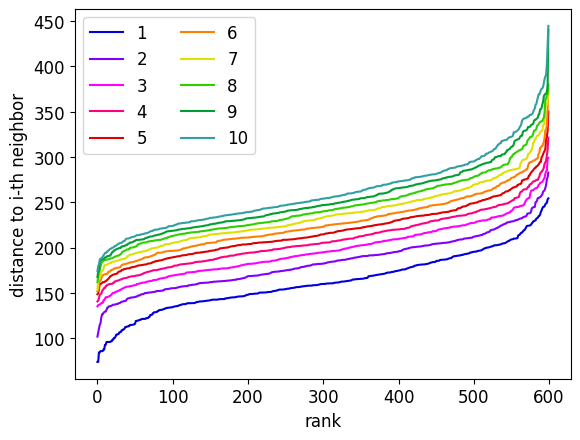

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T     ### distanza dell'i-esimo vicino per tutti i punti
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)


## t-SNE visualization, for true labels

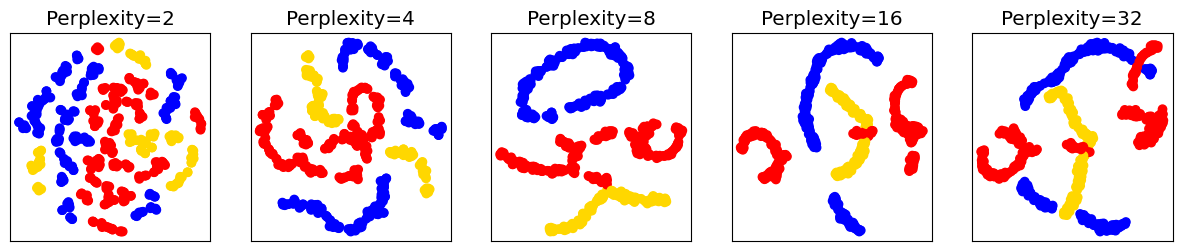

In [4]:
n_samples = N
n_components = 2
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

plt.show()

## Different random initial states (random_state=i)

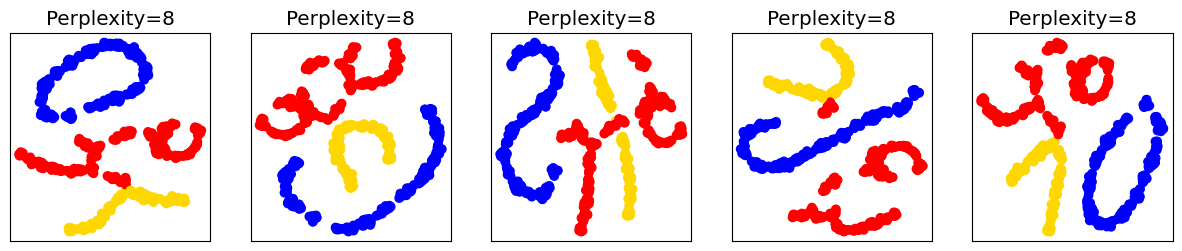

In [5]:
n_samples = N
n_components = 2
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i)
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components,
                         init='random',random_state=i,
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

plt.show()

## DBSCAN: find labels by applying clustering

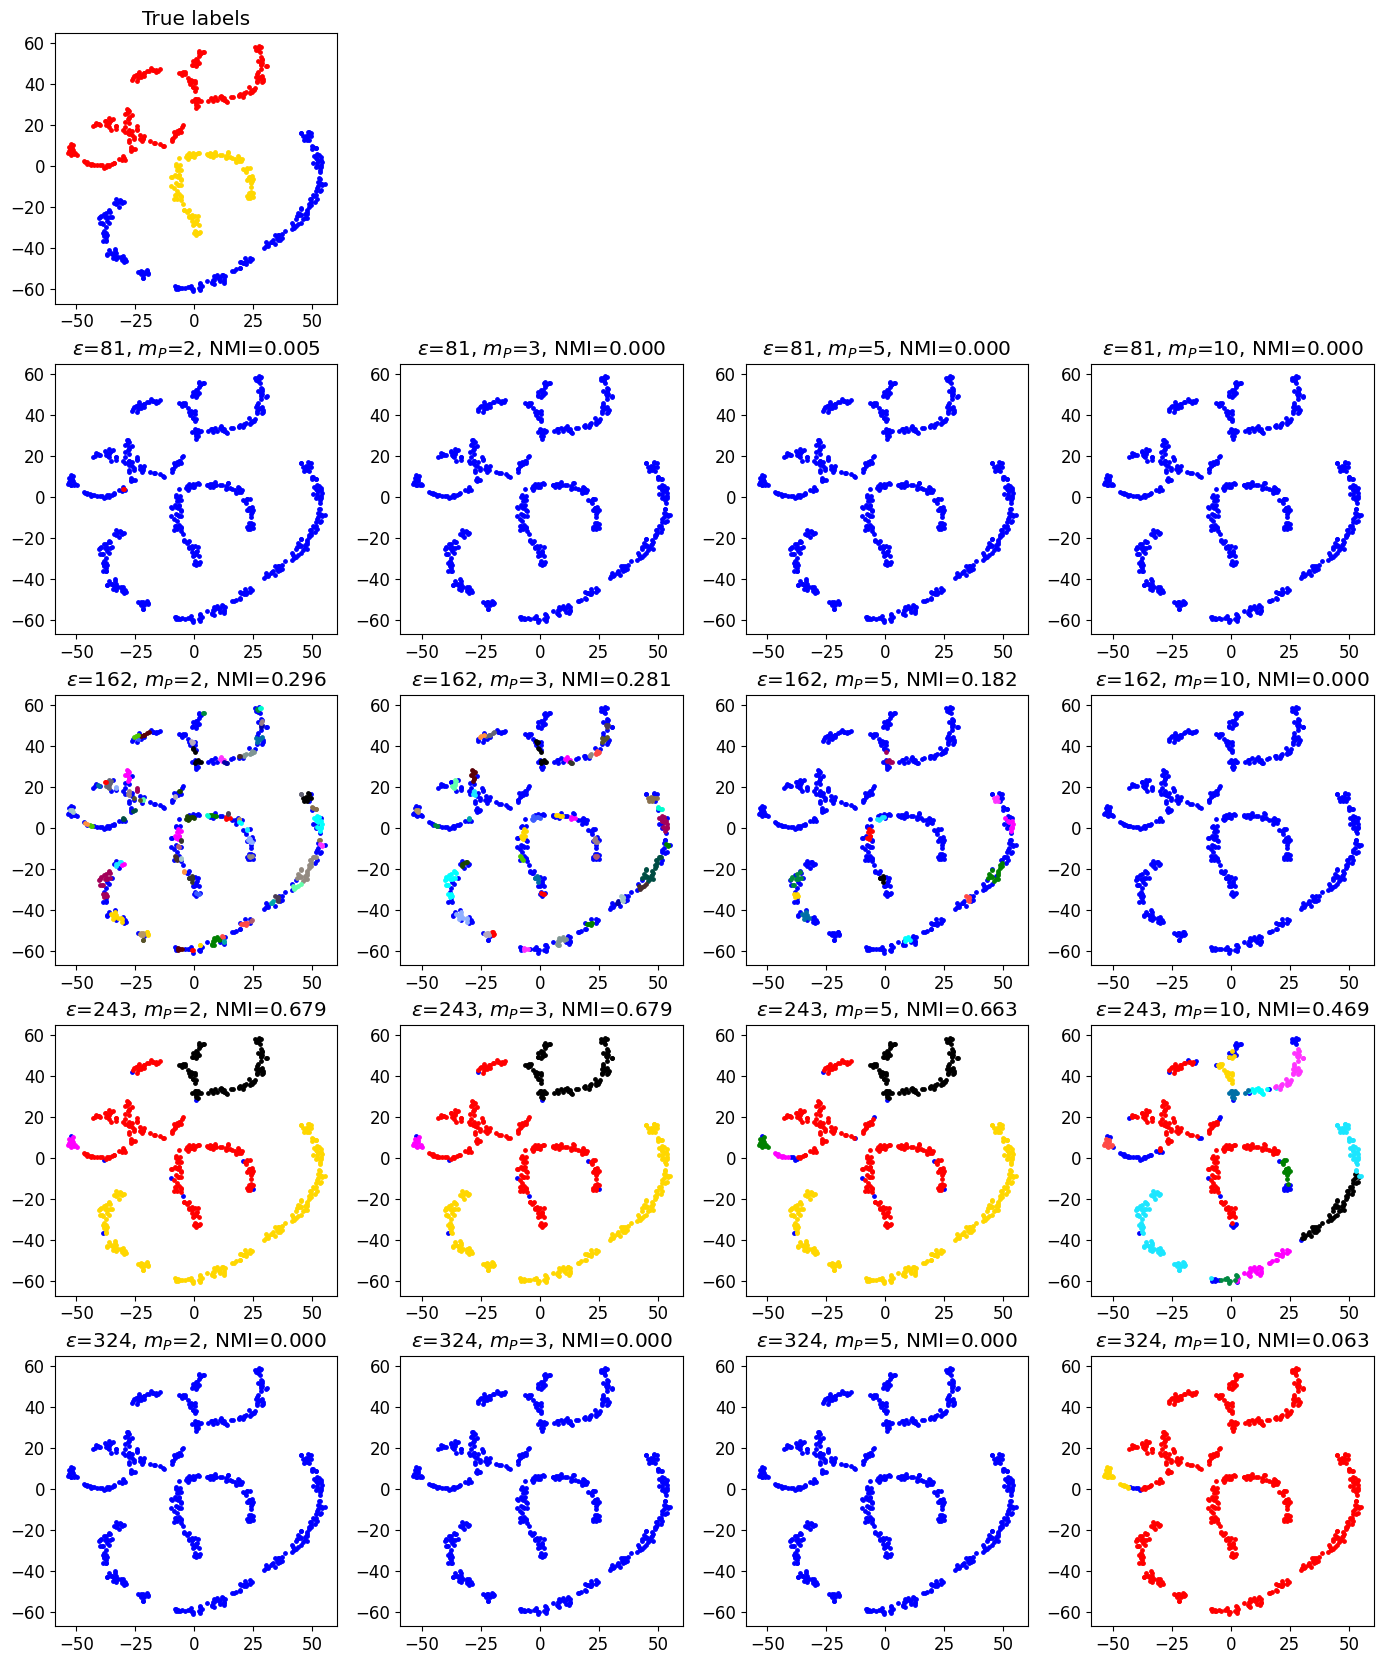

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample
                )
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]

min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(14,16.8))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))


plt.tight_layout(h_pad=0.5)
plt.show()


# 1. DBSCAN for different values of $ \epsilon $, $ m_P $ and NMI heat-map

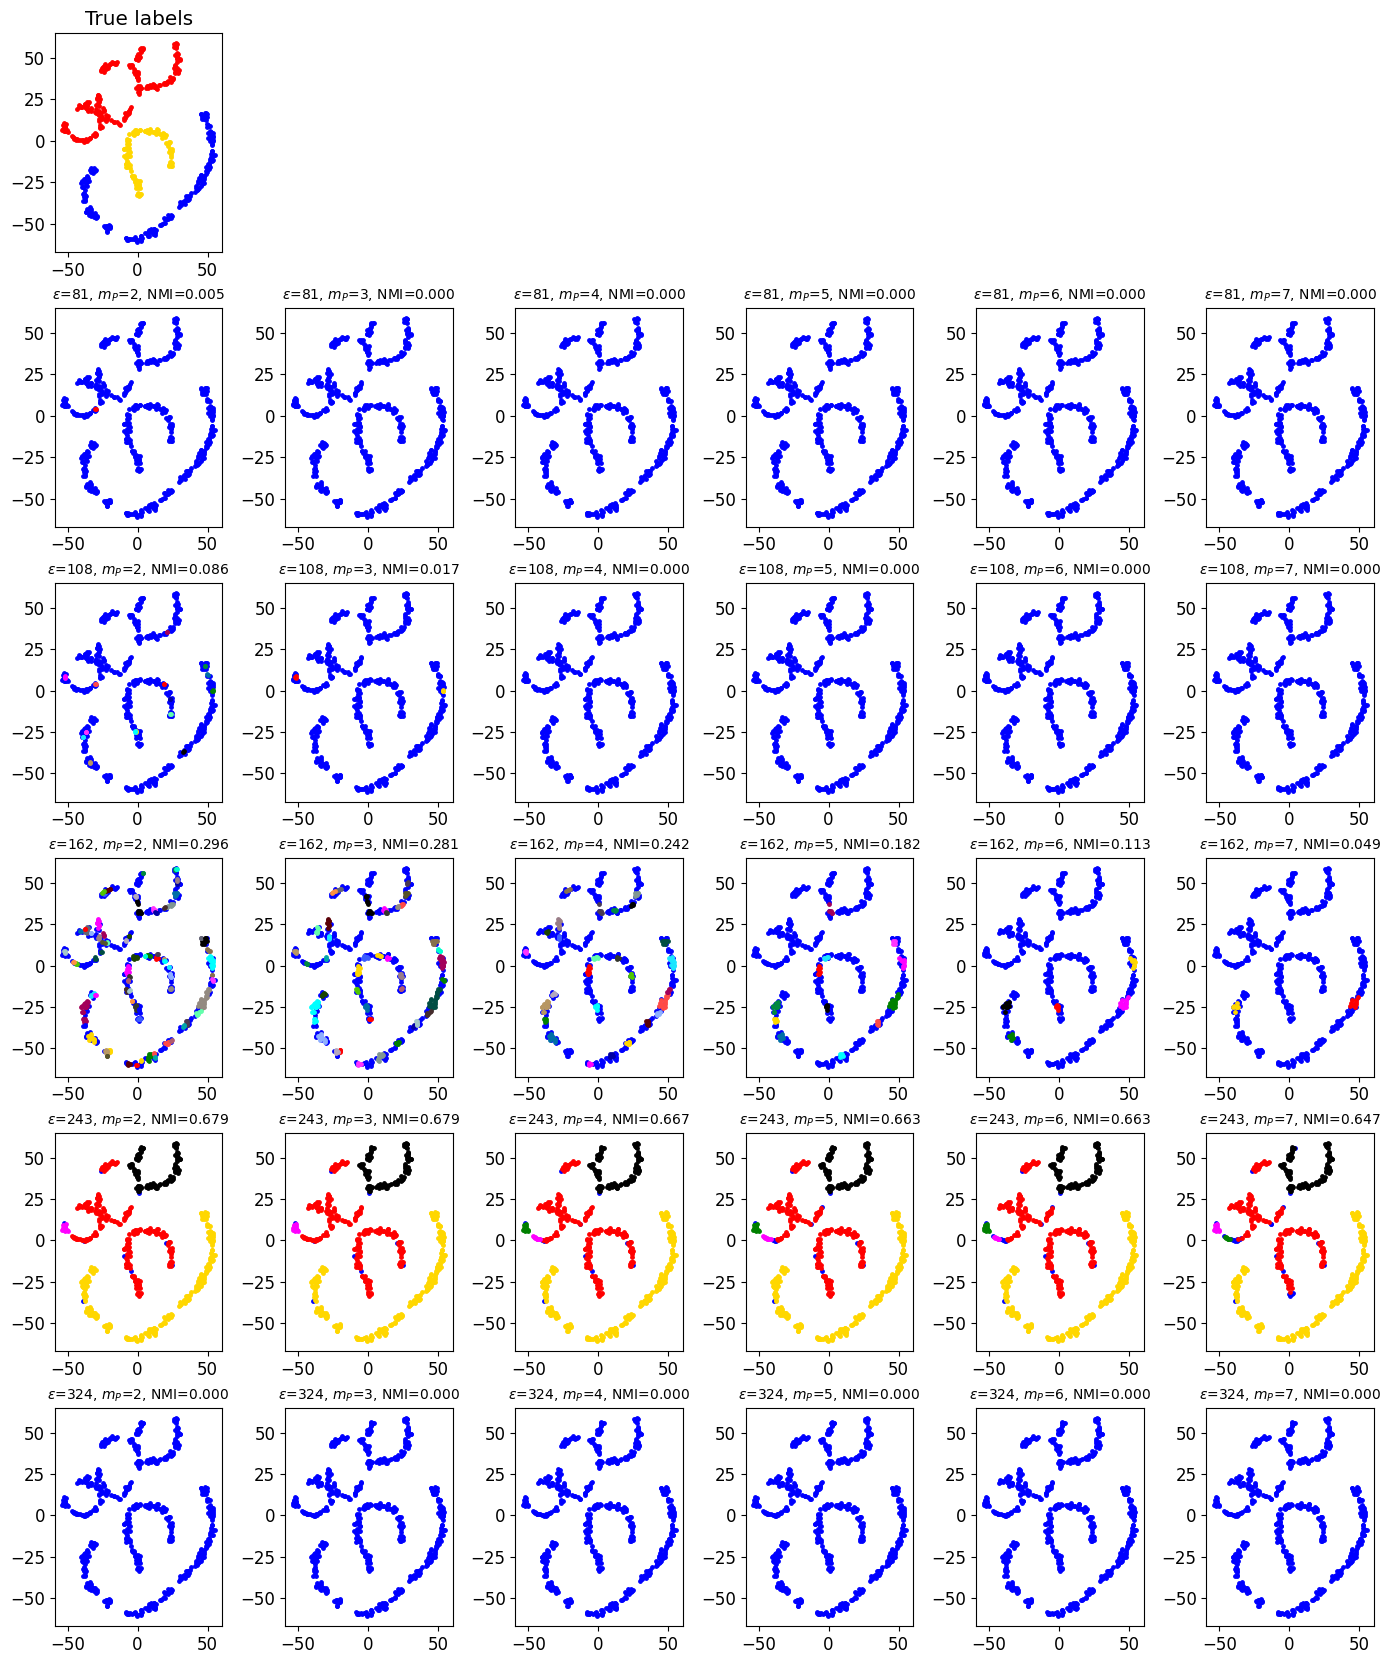

In [7]:
n_true_center=3
X2D = X_all[2]
X = data
y_true = y

if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
    
eps_range = [r/2, r/1.5, r, 1.5*r, 2*r]
min_sample_range = [2, 3, 4, 5, 6, 7] #[2, 3, 5, 7, 10]

#eps_range = [r/2,r/1.75,r/1.5,r/1.25,r,1.25*r,1.5*r,1.75*r,2*r]
#min_sample_range = [2,3,4,5,6,8,10,12,15]

DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(14,16.8))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi), size=10)


plt.tight_layout(h_pad=0.5)
plt.show()

In [ ]:
X2D = X_all[2]
X = data
y_true = y

if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)

min_sample_range = [i for i in range(2,50)]
eps_range = [i for i in range(1,3*r)]

nmi_matrix = np.zeros((len(eps_range), len(min_sample_range)))
for i, eps in enumerate(tqdm(eps_range, desc="Processing eps values")):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi=NMI(y_hat, y_true)
        nmi_matrix[i, j] = NMI(y_true, y_hat)

In [ ]:
df = pd.DataFrame(nmi_matrix, index=eps_range, columns=min_sample_range)
plt.figure(figsize=(10, 8))
sns.heatmap(df[::-1],cbar_kws={"label": "NMI","orientation": "horizontal"}, vmax=1)
plt.xlabel('$m_{p}$')
plt.ylabel('$\epsilon$')
plt.title("NMI heatmap")

plt.show()

In [ ]:
'''
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T     ### distanza dell'i-esimo vicino per tutti i punti

min_sample_range = [1, 2, 3, 4, 5]

for i in min_sample_range:
    mean_min_dist = np.mean(dd[i])
    print(f"mean minimum distance between the {i}th neighbor: ", round(mean_min_dist))
'''

In [ ]:
n_true_center=3
X2D = X_all[2]
X = data
y_true = y

if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
    
eps_range = [235, 240, 242, 245]
min_sample_range = [1, 2, 3, 4, 5]

DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(14,16.8))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))


plt.tight_layout(h_pad=0.5)
plt.show()


# 2. PCA

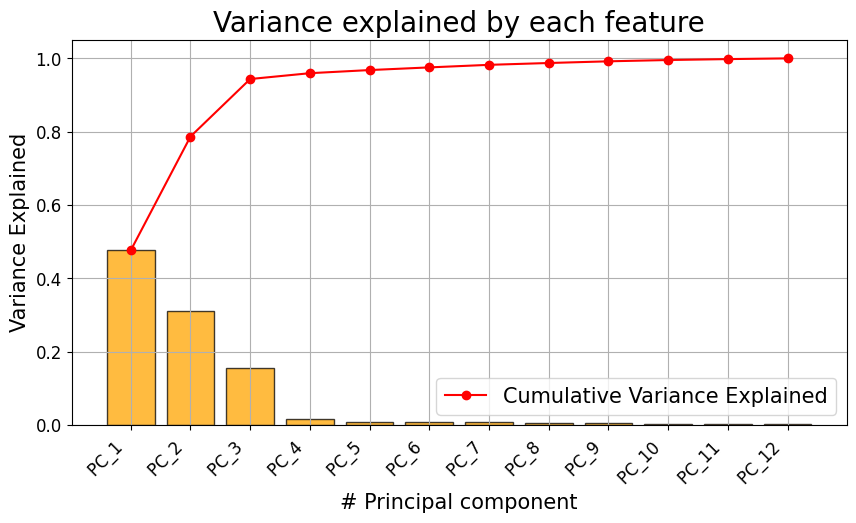


Variance explained by each feature:
PC1: 47.64%
PC2: 31.04%
PC3: 15.69%
PC4: 1.59%
PC5: 0.85%
PC6: 0.73%
PC7: 0.70%
PC8: 0.50%
PC9: 0.46%
PC10: 0.35%
PC11: 0.25%
PC12: 0.20%

Cumulative variance explained:
First 2 PCs: 78.68%
First 3 PCs: 94.37%


In [8]:
data = data.copy()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(data)

pca = PCA() 
x_PCA = pca.fit_transform(x_scaled)
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

pca_list = [f"PC_{i+1} "for i in range(len(explained_var))]

fig = plt.figure(figsize=(10, 5))

plt.bar(pca_list, explained_var, color='Orange', edgecolor='black',alpha=0.75)
plt.plot(pca_list, cumulative_var, label='Cumulative Variance Explained', marker='o', color='red')
plt.ylabel('Variance Explained',fontsize=15)
plt.xlabel('# Principal component',fontsize=15)

plt.title('Variance explained by each feature',fontsize=20)
plt.legend(loc='best',fontsize=15)

plt.xticks(rotation=45, ha='right', fontsize=45)  
plt.tick_params(axis='y', labelsize=12) 
plt.tick_params(axis='x', labelsize=12)
plt.grid()
plt.show()


print("\nVariance explained by each feature:")
for i, ratio in enumerate(explained_var, 1):
    print(f"PC{i}: {ratio*100:.2f}%")

print("\nCumulative variance explained:")
print(f"First 2 PCs: {cumulative_var[1]*100:.2f}%")
print(f"First 3 PCs: {cumulative_var[2]*100:.2f}%")

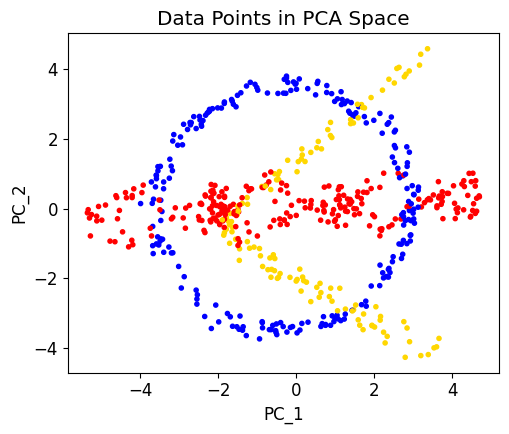

In [9]:
plt.figure(figsize=(7*0.75, 6*0.75))
plt.scatter(x_PCA[:, 0], x_PCA[:, 1], c = y, cmap = mycmap, marker='.')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.title('Data Points in PCA Space')
plt.tight_layout()
plt.show()

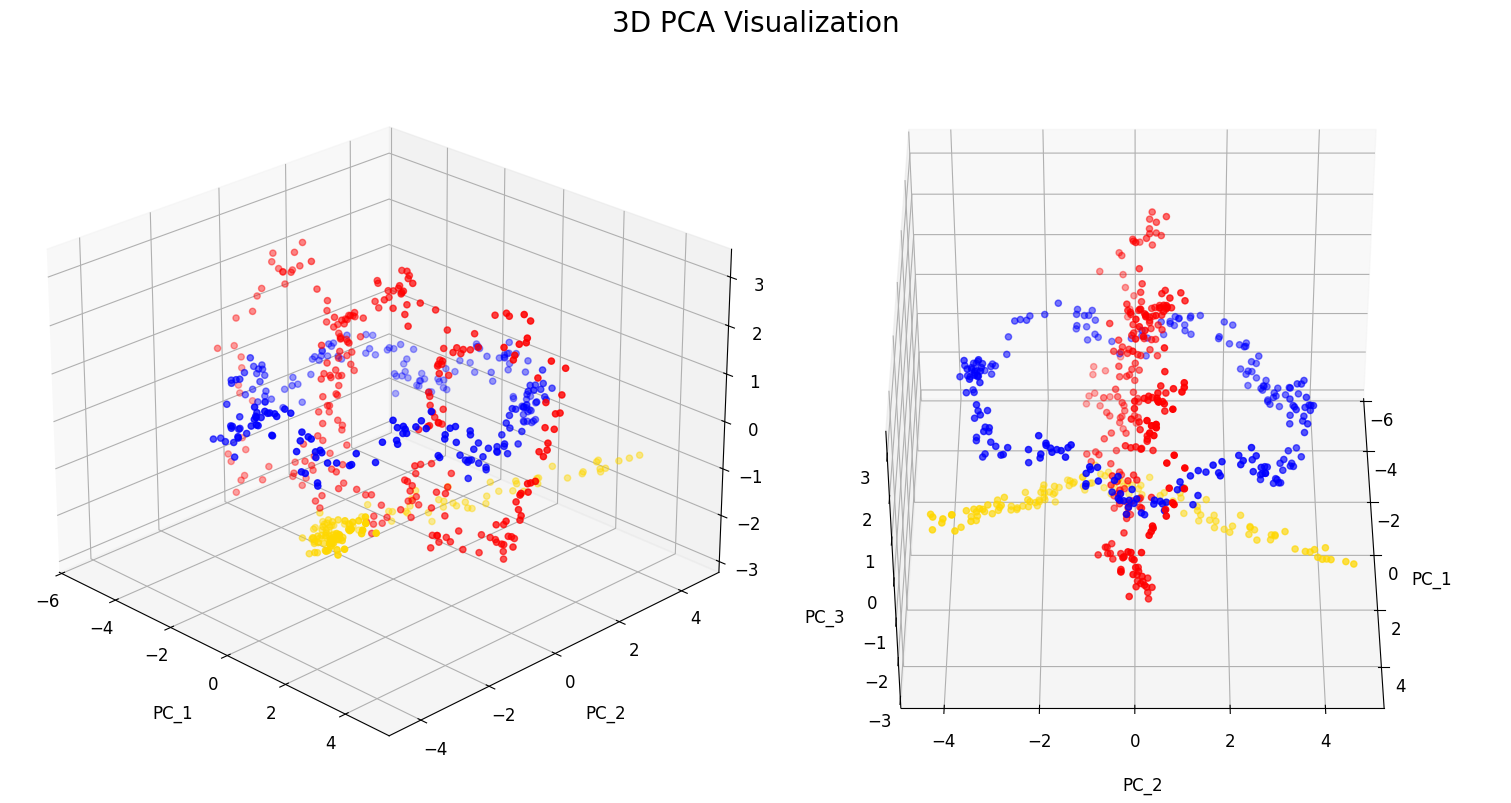

In [10]:
def create_pca_3d_plot(x_PCA, y, mycmap):
    
    fig = plt.figure(figsize=(15, 8), constrained_layout=True)

    for i in range(2):
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        
        scatter = ax.scatter(x_PCA[:, 0], x_PCA[:, 1], x_PCA[:, 2], c = y, cmap = mycmap)
        
        ax.view_init(elev=25+15*i, azim=45*(i-1))
        
        ax.set_xlabel('PC_1', fontsize=12, labelpad=15)
        ax.set_ylabel('PC_2', fontsize=12, labelpad=15)
        ax.set_zlabel('PC_3', fontsize=12, labelpad=15)
        
            
    plt.suptitle('3D PCA Visualization', fontsize=20)
    plt.show()

create_pca_3d_plot(x_PCA, y, mycmap)

## t-SNE visualization (after PCA)

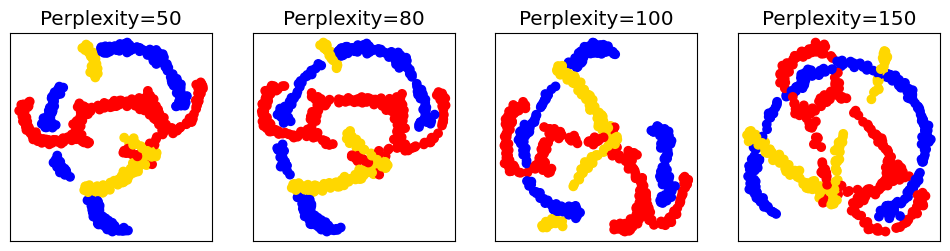

In [11]:
n_samples = N
n_components = 2
perplexities = [50,80,100,150]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1, Np, figsize=(3*Np, 2.7))

X_all_PCA = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y_PCA = tsne.fit_transform(x_PCA)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y_PCA[:, 0], Y_PCA[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all_PCA.append(Y_PCA)

plt.show()

# 3. k-means clustering

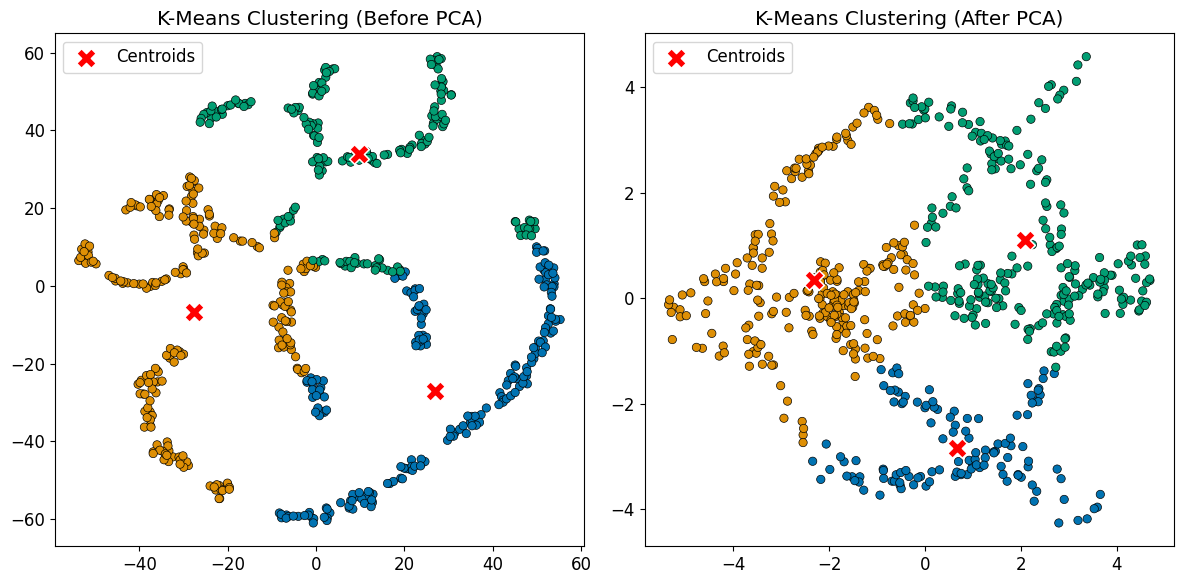

In [17]:
def compare_kmeans_clustering(data):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # K-means sui dati originali
    X2D = X_all[2]
    kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X2D)
    kmeans_labels = kmeans.labels_
    
    sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=kmeans_labels, palette='colorblind', edgecolor='k', legend=False, ax=ax1)
    sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200, label='Centroids', ax=ax1)
    ax1.set_title("K-Means Clustering (Before PCA)")
    ax1.legend()
    
    # K-means sui dati PCA
    kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(x_PCA)
    kmeans_labels = kmeans.labels_
    
    sns.scatterplot(x=x_PCA[:, 0], y=x_PCA[:, 1], hue=kmeans_labels, palette='colorblind', edgecolor='k', legend=False, ax=ax2)
    sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200, label='Centroids', ax=ax2)

    ax2.set_title("K-Means Clustering (After PCA)")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

compare_kmeans_clustering(data)

# PART 4

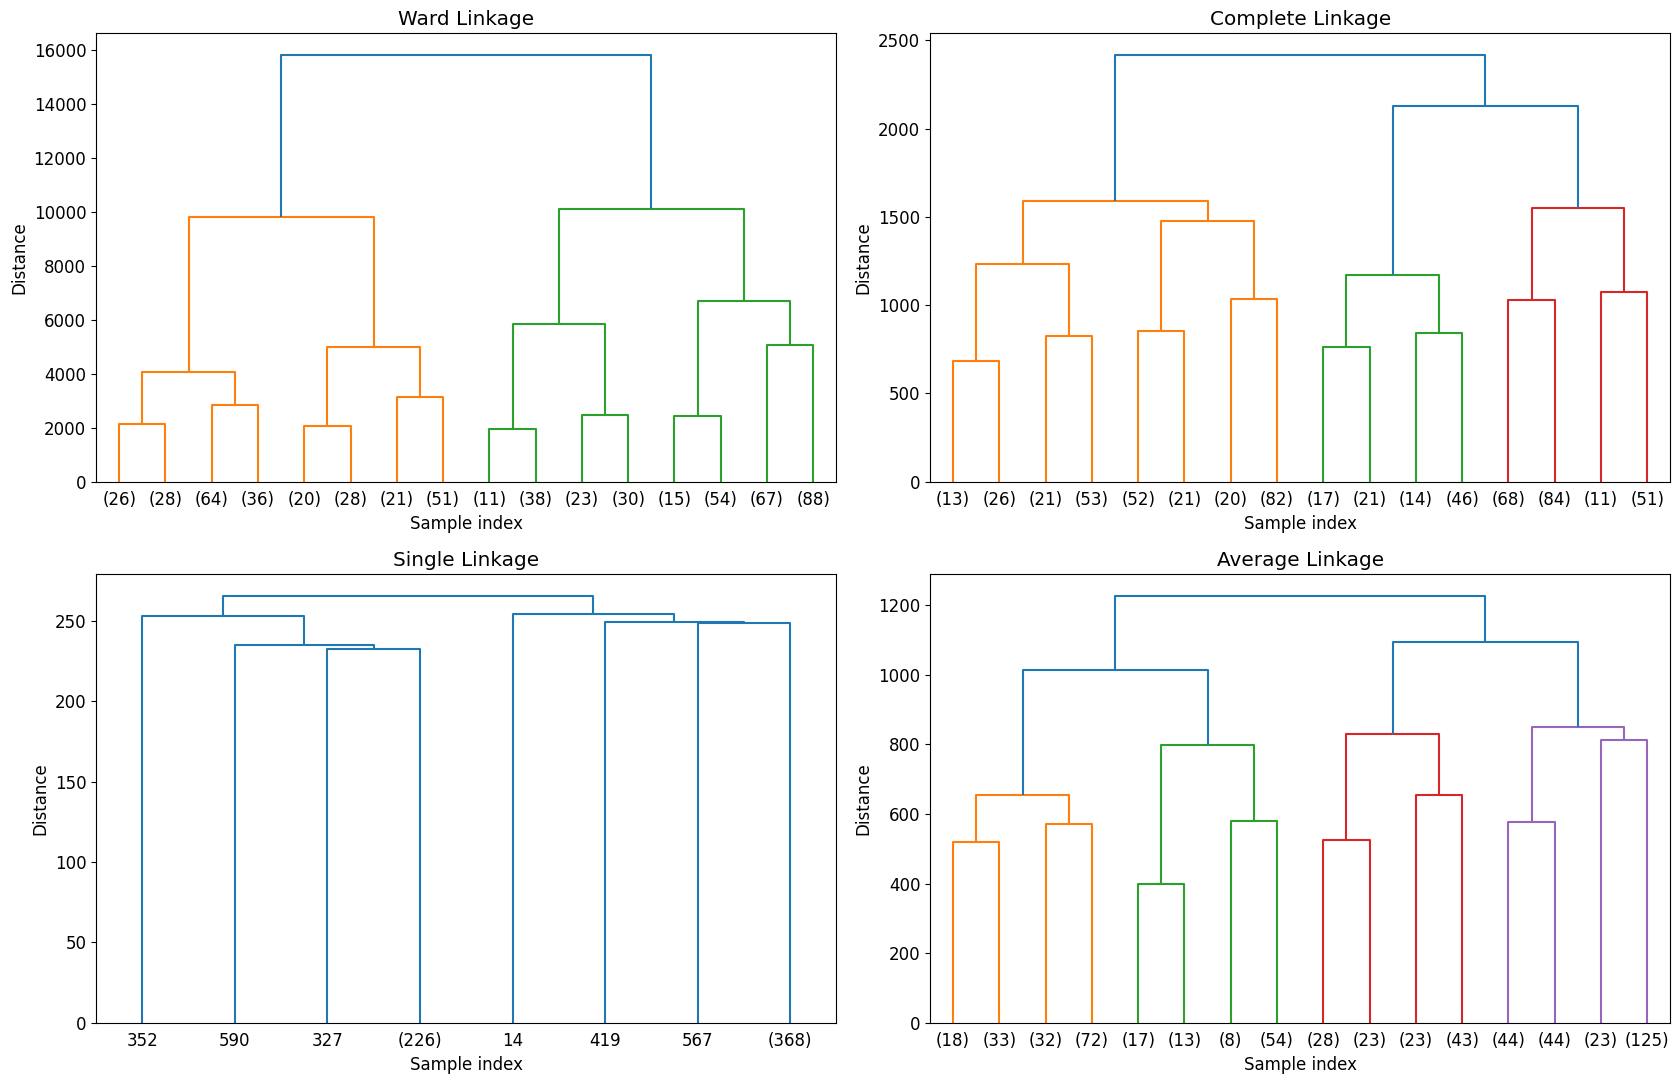

In [28]:
methods = ['ward', 'complete', 'single', 'average']
titles = ['Ward Linkage', 'Complete Linkage', 'Single Linkage', 'Average Linkage']

linked_tot=[]
fig, axes = plt.subplots(2, 2, figsize=(17, 11))
for ax, method, title in zip(axes.flatten(), methods, titles):
    linked = linkage(X, method=method)
    den=dendrogram(linked, p=3, truncate_mode='level', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Sample index")
    ax.set_ylabel("Distance")
    linked_tot.append(linked)
plt.tight_layout()
plt.show()